In [1]:
import sys
import subprocess
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seismic-library/')
import kaggle_support as kgs
import importlib
import time
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import cupy as cp
import copy
import seis_forward2

In [2]:
data = kgs.load_all_train_data(validation_only=True) + kgs.load_all_test_data()
data = data

In [3]:
folder = kgs.cache_dir_read + '/TV2D/'
#files_default = glob.glob(folder + '/*')
#files_default = ([os.path.basename(f) for f in files_default])
#files_default = set(files_default)
files_todo = ([os.path.basename(f) for f in glob.glob(folder + '/*')])
files_todo = set(files_todo)

In [6]:
def get_data_from_file(f):
    data = kgs.dill_load(f)[0]
    return data
res = dict()
res['cache_name'], res['is_train'], res['update_mae'], res['score_brendan'], res['score'], res['seis_err_rms'] = [],[],[],[],[],[]
for d in tqdm(data):
    f = d.cache_name()
    if f in files_todo:
        vel_default = get_data_from_file(folder +f)
        vel_brendan = get_data_from_file(kgs.cache_dir_read + '/brendan/' +f)
        res['cache_name'].append(f)
        res['is_train'].append(d.is_train)
        res['update_mae'].append(np.mean(np.abs(vel_default.data-vel_brendan.data)))
        if d.is_train:
            d.velocity.load_to_memory()
            res['score'].append(np.mean(np.abs(vel_default.data-cp.asnumpy(d.velocity.data))))
            res['score_brendan'].append(np.mean(np.abs(vel_brendan.data-cp.asnumpy(d.velocity.data))))
            d.velocity.unload()
        else:
            res['score'].append(np.nan)
            res['score_brendan'].append(np.nan)
        vel = copy.deepcopy(vel_default)
        vel.to_cupy()
        vel.data = vel.data.astype(cp.float64)
        vel.min_vel = vel.min_vel.astype(cp.float64)
        seis = kgs.Seismogram()
        seis.from_vector(seis_forward2.vel_to_seis(vel.to_vector())[0])
        d.seismogram.load_to_memory()
        res['seis_err_rms'].append(kgs.rms(seis.to_vector() - d.seismogram.to_vector()).get())
        d.seismogram.unload()
df = pd.DataFrame(res)
tr = df['is_train']
ntr = np.logical_not(df['is_train'])

100%|████████████████████████████████████████████████████████████████████████████| 70818/70818 [18:15<00:00, 64.64it/s]


In [5]:
%debug

> f:\seismic\code\core\seis_forward2.py(54)vel_to_seis()
     52     do_diff = not (vec_diff is None)
     53     do_adjoint = not (vec_adjoint is None)
---> 54     assert vec.dtype == kgs.base_type_gpu
     55     assert vec_diff is None or vec_diff.dtype == kgs.base_type_gpu
     56     assert vec_adjoint is None or vec_adjoint.dtype == kgs.base_type_gpu



ipdb>  vec.dtype


dtype('float32')


ipdb>  u


> c:\users\jeroe\appdata\local\temp\ipykernel_14840\4028820083.py(25)<module>()



ipdb>  u


*** all frames above hidden, use `skip_hidden False` to get get into those.


ipdb>  q


In [7]:
np.sum(df['is_train']), np.sum(np.logical_not(df['is_train']))

(1206, 17553)

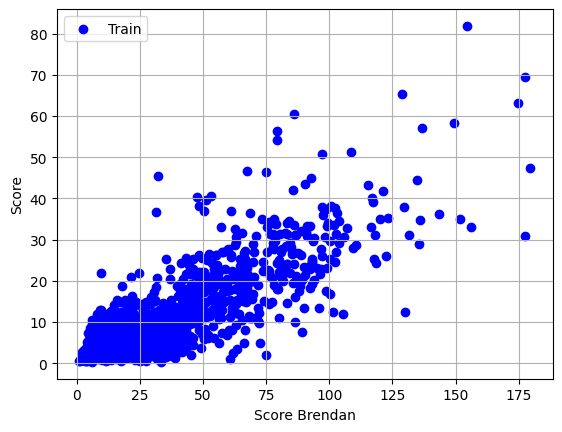

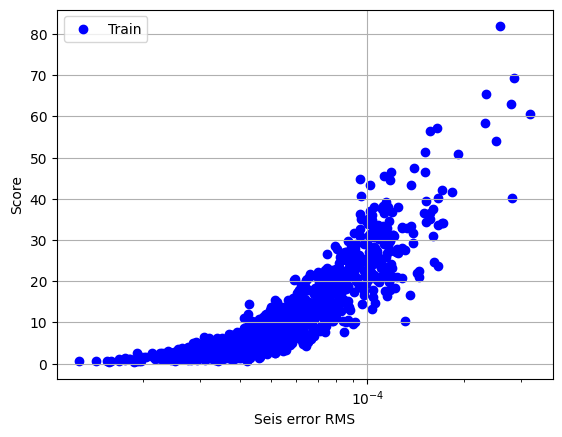

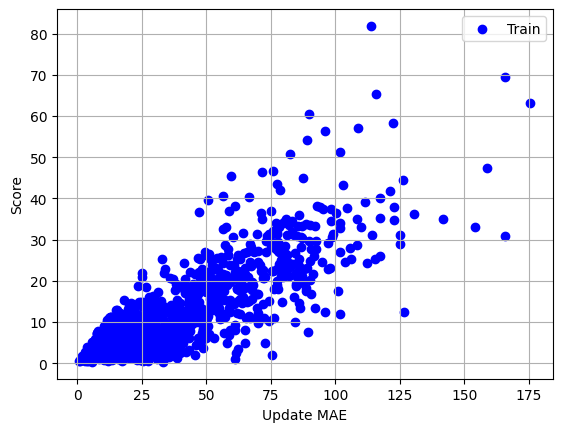

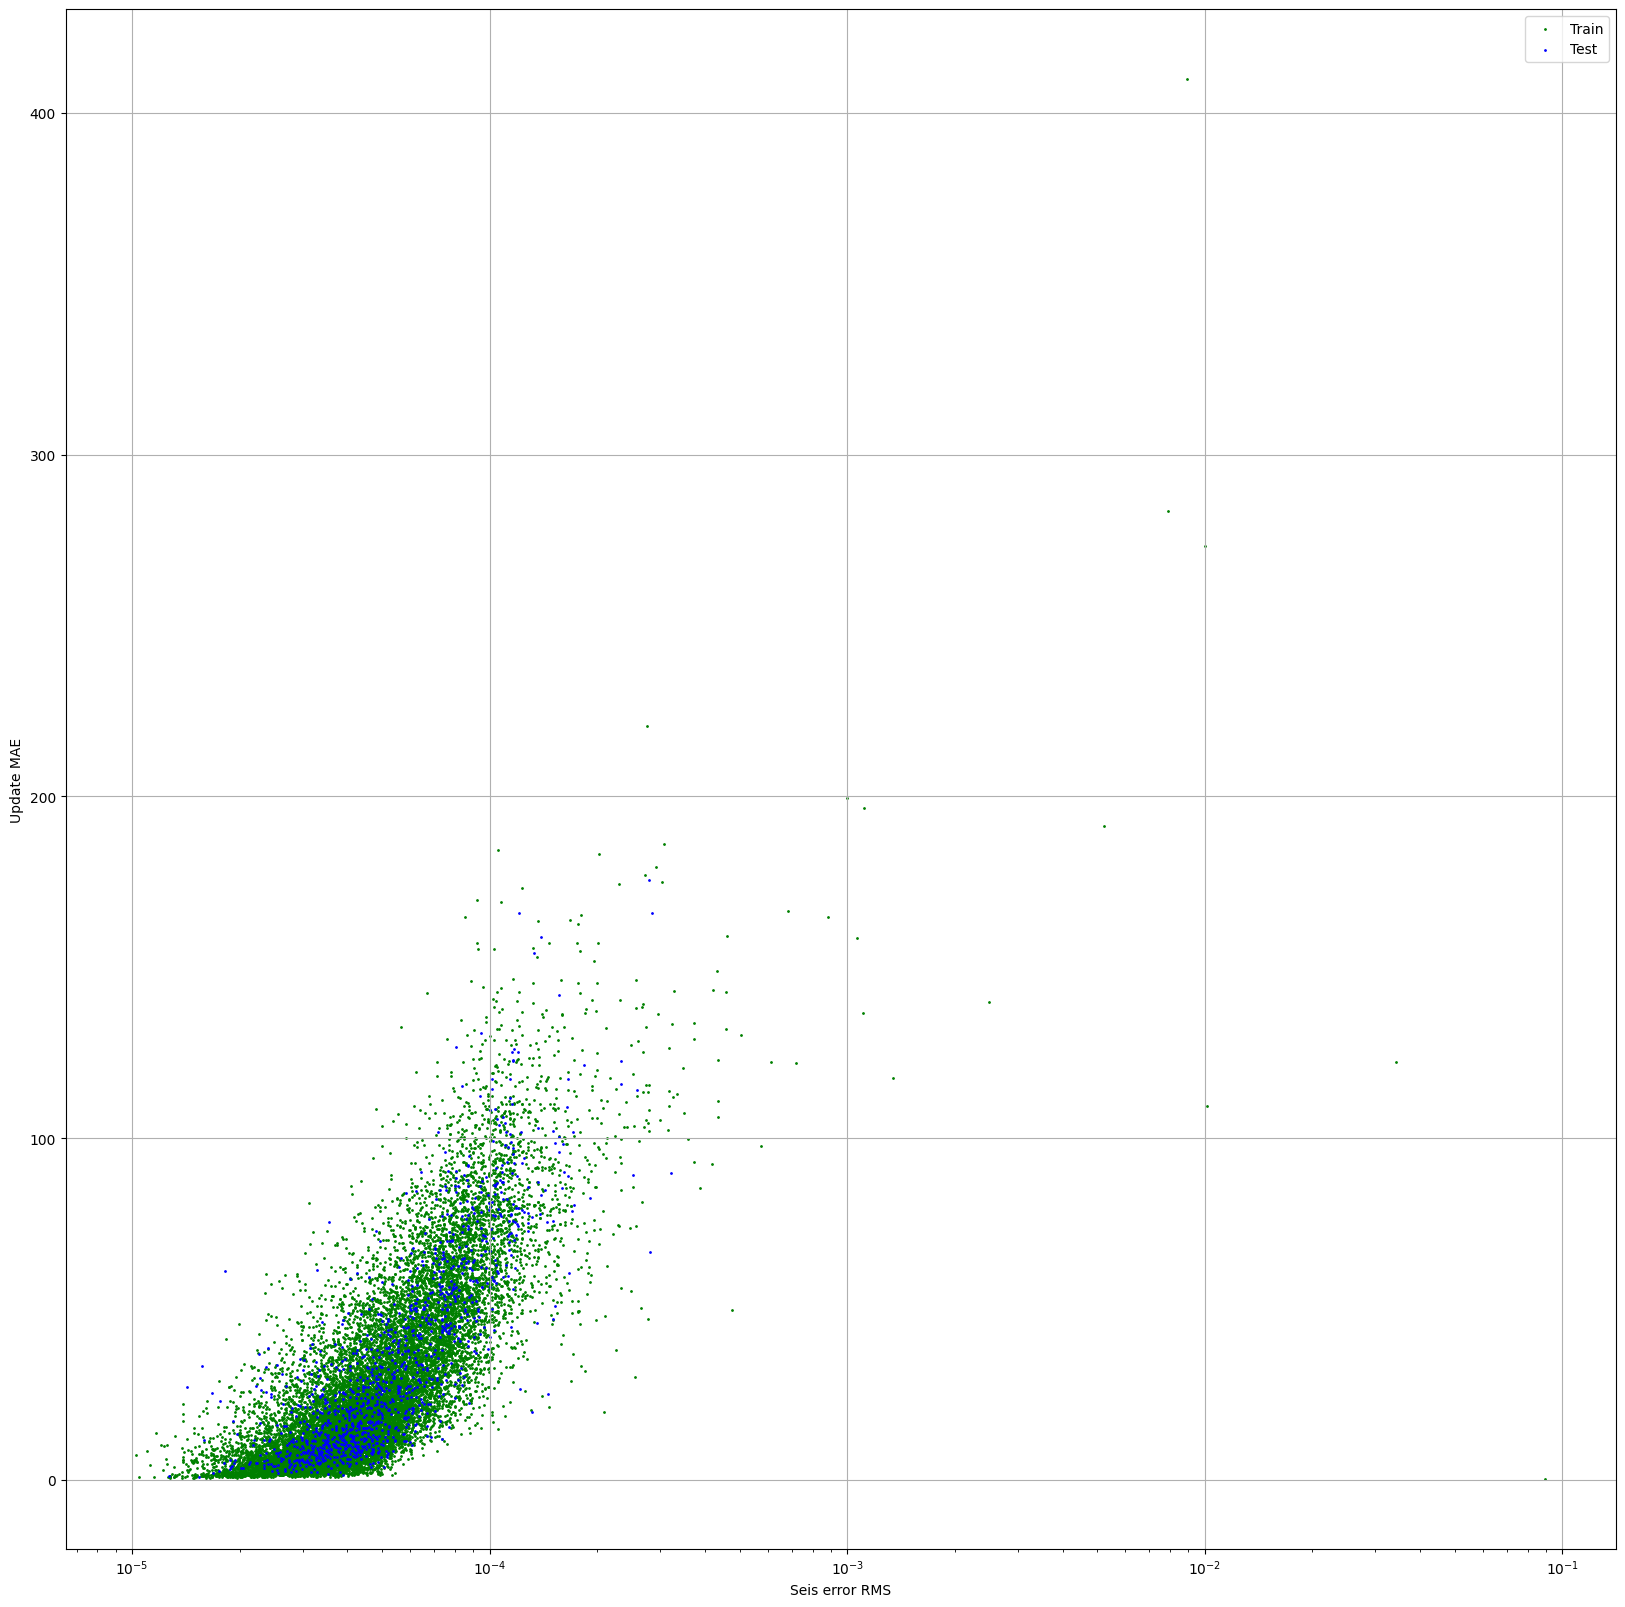

In [12]:
plt.figure();plt.scatter(df[tr]['score_brendan'],df[tr]['score'],color='blue');plt.xlabel('Score Brendan');plt.ylabel('Score');plt.legend(('Train',));plt.grid(True);
plt.figure();plt.scatter(df[tr]['seis_err_rms'],df[tr]['score'],color='blue');plt.xlabel('Seis error RMS');plt.ylabel('Score');plt.legend(('Train',));plt.grid(True);plt.xscale('log');
plt.figure();plt.scatter(df[tr]['update_mae'],df[tr]['score'],color='blue');plt.xlabel('Update MAE');plt.ylabel('Score');plt.legend(('Train',));plt.grid(True);

plt.figure(figsize=(20,20));plt.scatter(df[ntr]['seis_err_rms'],df[ntr]['update_mae'],1,color='green');plt.scatter(df[tr]['seis_err_rms'],df[tr]['update_mae'],1,color='blue');
plt.xlabel('Seis error RMS');plt.ylabel('Update MAE');plt.legend(('Train','Test'));plt.grid(True);plt.xscale('log');

(array(0.00032183), array(0.08948991))

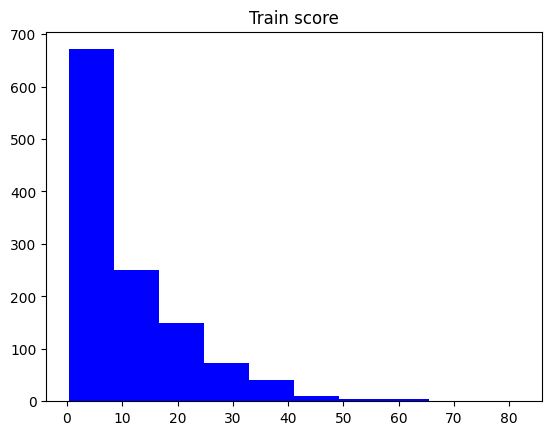

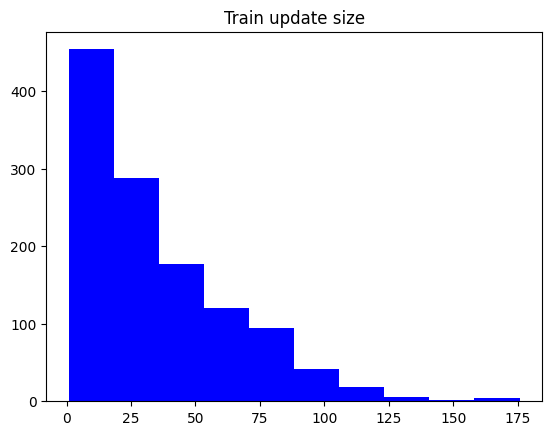

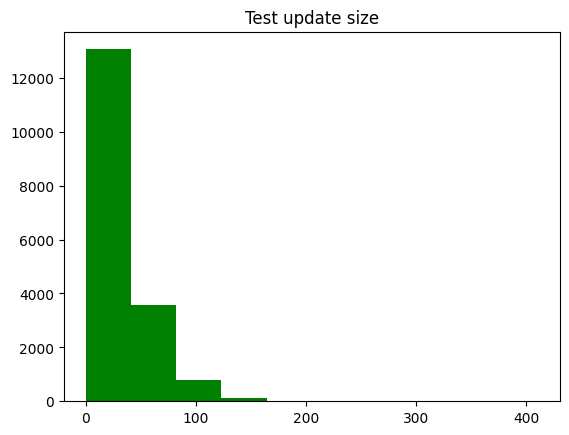

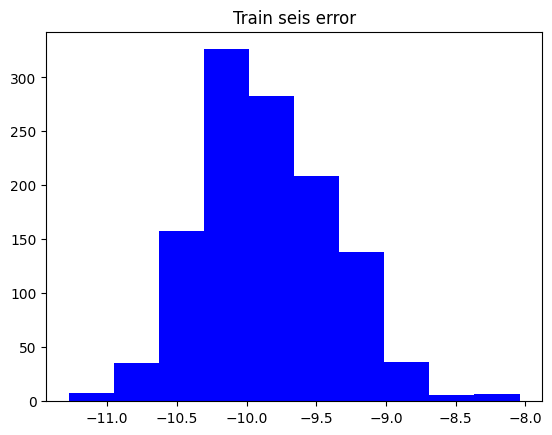

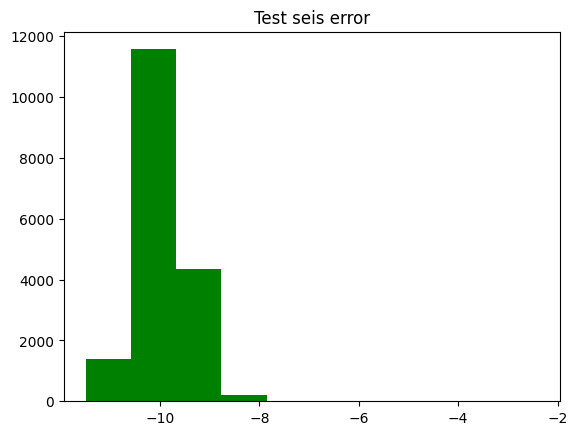

In [13]:
plt.figure();plt.hist(df[df['is_train']]['score'], color='blue');plt.title('Train score')
plt.figure();plt.hist(df[df['is_train']]['update_mae'], color='blue');plt.title('Train update size')
plt.figure();plt.hist(df[np.logical_not(df['is_train'])]['update_mae'], color='green');plt.title('Test update size')
plt.figure();plt.hist(np.log(np.array(list(df[df['is_train']]['seis_err_rms'].to_numpy()))), color='blue');plt.title('Train seis error')
plt.figure();plt.hist(np.log(np.array(list(df[ntr]['seis_err_rms'].to_numpy()))), color='green');plt.title('Test seis error')
np.max(df[tr]['seis_err_rms']), np.max(df[ntr]['seis_err_rms'])

In [ ]:
# for _,row in df.iterrows():
#     if row['seis_err_rms']>2e-4:
#         for d in data:
#             if d.cache_name() == row['cache_name']:
#                 #print(d.cache_name());
#                 #if not 'Style_A' in d.family:
#                 #print(row)
#                 f=d.cache_name()
#                 vel_default = get_data_from_file(folder +f)
#                 vel_brendan = get_data_from_file(kgs.cache_dir_read + '/brendan/' +f)
#                 _,ax = plt.subplots(1,3,figsize=(18,6))
#                 plt.sca(ax[0]);plt.imshow(vel_brendan.data);plt.title('NN prediction');plt.colorbar()
#                 plt.sca(ax[2]);plt.imshow(vel_default.data);plt.title('Final prediction');plt.colorbar()
#                 plt.sca(ax[1]);plt.imshow(vel_default.data-vel_brendan.data);plt.title('Update');plt.colorbar()
#                 print(np.mean(np.abs(vel_default.data-vel_brendan.data)))
#                 plt.suptitle(f + ', ' + str(row['score']))
#                 plt.pause(0.001)
#     if (row['is_train'] and row['score']>0.5):
#         for d in data:
#             if d.cache_name() == row['cache_name']:
#                 #print(d.cache_name());
#                 #if not 'Style_A' in d.family:
#                 #print(row)
#                 d.load_to_memory()
#                 vel_correct = d.velocity
#                 vel_correct.data = vel_correct.data.get()
#                 f=d.cache_name()
#                 vel_default = get_data_from_file(folder +f)
#                 vel_brendan = get_data_from_file(kgs.cache_dir_read + '/brendan/' +f)
#                 _,ax = plt.subplots(1,3,figsize=(18,6))
#                 plt.sca(ax[0]);plt.imshow(vel_default.data);plt.title('Final prediction');plt.colorbar()
#                 plt.sca(ax[1]);plt.imshow(vel_correct.data);plt.title('Correct');plt.colorbar()
#                 plt.sca(ax[2]);plt.imshow(vel_default.data-vel_correct.data);plt.title('Error');plt.colorbar()
#                 print(np.mean(np.abs(vel_default.data-vel_brendan.data)))
#                 plt.suptitle(f + ', ' + str(row['score']))
#                 plt.pause(0.001)

In [14]:
400*50/65000

0.3076923076923077

In [19]:
df2 = df[tr].sort_values('seis_err_rms', ascending=False)
df2

,cache_name,is_train,update_mae,score_brendan,score,seis_err_rms
885,data1__CurveVel_B__474,True,89.876065,85.838707,60.520584,0.0003218292498161744
10,seis6_1_0__CurveFault_B__8,True,165.773223,177.587273,69.432467,0.0002854671616797731
624,data1__CurveVel_B__35,True,66.630970,47.532565,40.239705,0.00028125174654326167
871,data1__CurveVel_B__450,True,175.657739,174.900412,63.128674,0.00027943212317073905
791,data1__CurveVel_B__315,True,113.965079,154.409762,81.866355,0.00025811674102105725
...,...,...,...,...,...,...
739,data1__CurveVel_B__228,True,11.743923,11.436724,0.596577,1.5864380064889553e-05
633,data1__CurveVel_B__50,True,33.279155,33.185964,0.367491,1.566937312972928e-05
904,seis2_1_0__FlatFault_A__300,True,0.825650,1.031628,0.550116,1.5393009530554493e-05
836,data1__CurveVel_B__390,True,27.216177,27.271030,0.643798,1.4251460562677696e-05
